# Proportional Integral Derivative(PID) Controller
Proportional Integral Derivative (PID) control automatically adjusts a control output based on the difference between a set point (SP) and a measured process variable (PV). The value of the controller output $u(t)$ is transferred as the system input.
$$e(t) = SP-PV$$
$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\int_0^t e(t)dt - K_c \tau_D \frac{d(PV)}{dt}$$
$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\sum_{i=1}^{n_t} e_i(t)\Delta t  - K_c \tau_D \frac{PV_{n_t}-PV_{n_t-1}}{\Delta t}$$
The $u_{bias}$ term is a constant that is typically set to the value of $u(t)$when the controller is first switched from manual to automatic mode. This gives "bumpless" transfer if the error is zero when the controller is turned on.

PID controller is best suited for non-integrating processes, meaning any process that eventually returns to the same output given the same set of inputs and disturbances.

Derivative action is used to decrease the oscillations of PV(Process Variable)

## IMC(Internal Mode Control) Tuning Correlations:
$$\mathrm{Aggressive\,Tuning:} \quad \tau_c = \max \left( 0.1 \tau_p, 0.8 \theta_p \right)$$
$$\mathrm{Moderate\,Tuning:} \quad \tau_c = \max \left( 1.0 \tau_p, 8.0 \theta_p \right)$$
$$\mathrm{Conservative\,Tuning:} \quad \tau_c = \max \left( 10.0 \tau_p, 80.0 \theta_p \right)$$
$$K_c = \frac{1}{K_p}\frac{\tau_p+0.5\theta_p}{\left( \tau_c + 0.5\theta_p \right)} \quad \quad \tau_I = \tau_p + 0.5 \theta_p \quad \quad \tau_D = \frac{\tau_p\theta_p}{2\tau_p + \theta_p}$$

## Simple Tuning Rules:
Note that with moderate tuning and negligible dead-time $(\theta_p -> 0\ and \tau_c = 1.0 \tau_p)$, IMC reduces to simple tuning correlations that are easy to recall without a reference book.
$$K_c = \frac{1}{K_p} \quad \quad \tau_I = \tau_p \quad \quad \tau_D = 0 \quad \quad \mathrm{Simple\,tuning\,correlations}$$

## Optional Derivative Filter:
The optional parameter $\alpha$ is a derivative filter constant. The filter reduces the effect of measurement noise on the derivative term that can lead to controller output amplification of the noise.
$$\alpha = \frac{\tau_c\left(\tau_p+0.5\theta_p\right)}{\tau_p\left(\tau_c+\theta_p\right)}$$
The PID with the filter is augmented as:
$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\int_0^t e(t)dt - K_c \tau_D \frac{d(PV)}{dt} - \alpha \tau_D \frac{du(t)}{dt}$$

## Anti-Reset Windup:
An important feature of a controller with an integral term is to consider the case where the controller output $u(t)$ saturates at an upper or lower bound for an extended period of time. This causes the integral term to accumulate to a large summation that causes the controller to stay at the saturation limit until the integral summation is reduced. Anti-reset windup is that the integral term does not accumulate if the controller output is saturated at an upper or lower limit.

## Derivative Kick:
Derivative kick occurs because the value of the error changes suddenly whenever the set point is adjusted. The derivative of a sudden jump in the error causes the derivative of the error to be instantaneously large and causes the controller output to saturate for one cycle at either an upper or lower bound. While this momentary jump isn't typically a problem for most systems, a sudden saturation of the controller output can put undue stress on the final control element or potentially disturb the process.

To overcome derivative kick, it is assumed that the set point is constant with $(d(SP))/dt=0$

$$\frac{de(t)}{dt} = \frac{d\left(SP-PV\right)}{dt} = \frac{d\left(SP\right)}{dt} - \frac{d\left(PV\right)}{dt} = - \frac{d\left(PV\right)}{dt}$$
This modification avoids derivative kick but keeps a derivative term in the PID equation.



## Assignment: Concentration PID Control
Develop a controller to maintain outlet concentration.
<img src="http://apmonitor.com/pdc/uploads/Main/mixer_schematic.png" width="300" height="300">

Implement a PID controller that maintains the outlet concentration of A in the mixer by automatically adjusting the feed concentration. Assume that the concentration is continuously measured and that the controller should be designed to follow set point changes to 1.5 mol/L and then down to 1.0 mol/L. The maximum feed concentration is 2.0 mol/L and the minimum is 0.0 mol/L. Report the PID tuning parameters and show time plots of the dynamic response of the controller.

Assume feed temprature of 100K, constant tank volume V of 100 m3 and an inlet flow rate and outlet flow rate of 100 m3/hr.

#### Process Equation:
$$\frac{dc_A V}{dt} = c_{A_{in}} \dot V_{in} - c_{A_{out}} \dot V_{out}$$

#### Steps To Follow:
    1.Simulating Model
    2.FOPDT
    3.PID Tuning
    4.Simulating PID

In [17]:
#Importing Dependencies
from ipywidgets import interactive
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

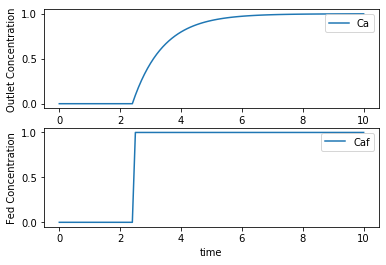

In [18]:
#Simulating Model
def mixer(Ca, t, Caf, Tf):
    #Inlet and Outlet Volumetric Flow Rates
    q = 100
    #Volume of mixer
    V = 100
    dCa = (q*(Caf - Ca))/V
    return dCa
    
def simModel():
    #Time span
    t = np.linspace(0, 10, 101)
    
    #Initial Constants
    Ca0 = 0
    Tf = 300
    
    #Storing feed concentration responses
    Caf = np.zeros(len(t))
    #Step-Adding through feed concentration
    Caf[25:] = 1
    
    #Storing outlet concentration response
    Ca = np.ones(len(t))*Ca0
    
    #Simulating Model
    for i in range(len(t) - 1):
        time = t[i:i+2]
        y = odeint(mixer, Ca0, time, args=(Caf[i+1], Tf))
        Ca0 = y[-1]
        Ca[i+1] = Ca0
    
    #Plotting
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t, Ca, label="Ca")
    plt.ylabel('Outlet Concentration')
    plt.legend(loc='best')
    
    plt.subplot(2,1,2)
    plt.plot(t, Caf, label="Caf")
    plt.ylabel('Fed Concentration')
    plt.xlabel('time')
    plt.legend(loc='best')
    plt.show()

simModel()

##### FOPDT
By analysing the above graph we find that:
1. $K_p$ = 1
2. $\theta_p$ = 0
3. $\tau_p$ = 1

##### PID Tuning
Using simple tuning we get:
$$K_c = \frac{1}{K_p}=1 \quad \quad \tau_I = \tau_p=1 \quad \quad \tau_D = 0 \quad \quad \mathrm{Simple\,tuning\,correlations}$$


In [39]:
#Simulating PID
def PID(Ca2, Ca1, SP, sum_int, delta_t, Kc, tauI, tauD, ubias):
    #Error: SP - PV
    error = SP - Ca2
    #Approximation of Integration of error
    sum_int = sum_int + error*delta_t
    #Approximation of Differentiation i.e d(PV)/dt
    derivative = (Ca2 - Ca1)/delta_t
    #Controller Output
    u = ubias + Kc*error + (Kc*sum_int)/tauI - (Kc*tauD*derivative)
    return u, error, sum_int, derivative

def simModelPID(Kc=1, tauI=1, tauD=0.0, ubias=0.0):
    #Time-Span
    t = np.linspace(0,10,101)
    delta_t = t[1] - t[0]
    #Initial Constants
    Ca0 = 0
    Tf = 300
    
    #Step-Adding through set points(of oulet concentration)
    SP = np.ones(len(t))*1.5
    SP[50:] = 1.0
    
    #Storing feed concentration responses
    Caf = np.zeros(len(t))
    
    #Storing outlet concentration response
    Ca = np.ones(len(t))*Ca0
    
    #Storing Propotional error responses
    er = np.zeros(len(t))
    #Storing Integral error responses
    ier = np.zeros(len(t))
    #Storing Derivative error responses
    der = np.zeros(len(t))
    
    #Simulating PID+Model
    sum_int = 0
    for i in range(len(t)-1):
        time = t[i:i+2]
        if i==0:
            u, error, sum_int, derivative = PID(Ca0, 0, SP[i], sum_int, delta_t, Kc, tauI, tauD, ubias)
        else:
            u, error, sum_int, derivative = PID(Ca0, Ca[i-1], SP[i], sum_int, delta_t, Kc, tauI, tauD, ubias)
        #Restricing feed concentration and Anti-Reset Wrapup
        if u>=2.0:
            u = 2
            sum_int = sum_int - error*delta_t
        elif u<=0.0:
            u = 0
            sum_int = sum_int - error*delta_t
        er[i+1] = error
        ier[i+1] = sum_int
        der[i+1] = derivative
        Caf[i+1] = u
        y = odeint(mixer, Ca0, time, args=(u, Tf))
        Ca0 = y[-1]
        Ca[i+1] = Ca0
        
    #Plotting
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(5,1,1)
    plt.plot(t,Ca,'r',label='Ca')
    plt.plot(t,SP,'b',label='Set Point')
    plt.plot(t, Caf, 'r--', label='Caf')
    plt.legend(loc='best')
    plt.ylabel('Outlet Concentration/Process Variable')

    plt.subplot(5,1,2)
    plt.plot(t, Caf, 'r-', label='Caf')
    plt.legend(loc='best')
    plt.ylabel('Feed Concentration/Controller Output')


    plt.subplot(5,1,3)
    plt.plot(t, er, 'g:')
    plt.ylabel('Proportional error')

    plt.subplot(5,1,4)
    plt.plot(t, ier, 'r:')
    plt.ylabel('Integral Error')
    
    plt.subplot(5,1,5)
    plt.plot(t, der, 'k:')
    plt.ylabel('Derivative Error')
    plt.xlabel('Time')
    plt.show()

In [40]:
interactive_plot = interactive(simModelPID, Kc=(-5.0,10.0), tauI=(0,50.0), tauD=(0, 50.0), ubias=(-1.0,5.0))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='Kc', max=10.0, min=-5.0), FloatSlider(value=1.0, des…